In [ ]:

import numpy as np
import torch
import torch
from egnn_pytorch import EGNN_Network

import torch.nn as nn
import numpy as np
import random
import torch.nn.functional as F
import itertools

import torch
from matplotlib import pyplot as plt

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from collections import defaultdict

charges = {'HIS': 1, 'LYS': 1,
           'ASP': -1, 'GLU': -1,  # carboxylate
           'CYS': 0, 'CYS': 0,
           'TYR': 0}   # thiol and phenol prot

cations = {'HIS': ("HD1", "HD2", "HE1", "HE2"),
        'ASP':None,
        "LYS":("HZ1", "HZ2","HZ3"),
        "TYR":"HH",
        "GLU":None,
        "CYS":'HG',
        "ARG": ("HE11","HE12", "HE21", "HE22"),
        "THR":"HG1",
        "SER":"HG",
        "TRP":"HE1"}


anions = {"HIS":("ND1", "ND2"),
          "ASP":("OD1","OD2"),
          "LYS":"NZ",
          "TYR":"OH",
          "GLU":("OE1", "OE2"),
          "CYS":"SG",
          "ARG": ("NE1","NE2"),
          "THR":"OG1",
          "SER":"OG",
          "TRP":"NE1"}


def load_pdb(path):
    with open(path, "r") as f:
        resis = {}
        xs = []
        counter=0
        for line in f:
            L = line.split()

            if line.startswith("ATOM"):
                resname, atomname = L[3], L[2]
                if resname in prot:
                    resname = resname + str(L[5]) + L[4]

                    if resname in resis:
                        resis[resname][f"{atomname} {counter}"] = (float(L[6]), float(L[7]), float(L[8]))
                        counter += 1
                    else:
                        resis[resname] = {f"{atomname} {counter}": (float(L[6]), float(L[7]), float(L[8]))}
                        counter += 1

                else:  # resname in noprot
                    resname, atomname, resnum = L[3], L[2], L[5]
                    xs.append((float(L[6]), float(L[7]), float(L[8])))
                    counter += 1

            elif line.startswith("HETATM"):
                resname = L[3] + str(L[5])
                atomname = L[2]
                if resname in solvents:
                    solvents[resname][f"{atomname} {str(counter)}"] = (float(L[6]), float(L[7]), float(L[8]))
                    counter += 1
                else:
                    solvents[resname] = {f"{atomname} {str(counter)}": (float(L[6]), float(L[7]), float(L[8]))}
                counter += 1
    #print(resis)
    return resis

#load_pdb()
import glob
import dask.dataframe as dd


prot = charges.keys()

Rs, solvents, counter = {}, {}, 0

all_ppos, all_pspecies = {}, {}
positions = []
s={}
all_ions={}


directory = '/home/jrhoernschemeyer/Desktop/thesis/"

all_targets={}

    
data, pkpdb, pdbs = get_pdbs_labels(directory)

for pdb in pdbs:
    d = df[df.iloc[:, 0] == pdb].drop(columns = ["idcode"])
    all_targets[pdb] = group_by_category(d.compute().to_dict(orient="records"))

def get_pdbs_labels(directory):
    """gets the data dictionary and [pdb string names] 

    inputs: path to directory where input structures are saved"""
    pdbids, data =[],{}
    
    for file in glob.glob(directory + "/PDB/*red.pdb"):
        pdbids = file[-12:-8]
        data[pdb] = load_pdb(file)
        pdbids.append(pdb)
    
   

    return data, dd.read_csv(directory + "/pkas.csv", sep=';'), pdbids


def group_by_category(data_list):
    #targets = defaultdict(list)
    targets={}
    for item in data_list:
        num, resi, chain, pk = item['residue_number'], item['residue_name'], item["chain"], item["pk"]
        targets[resi+str(num)+chain]= pk 
    
    return targets




def boltzmax(x, temp):
    """
    Computes Boltzmann probabilities (Euclidean Softmax) for a tensor of distances.
    
    Parameters:
        distances (torch.Tensor): feature tensor
        temperature (float): The temperature parameter to control the sharpness.
    
    Returns:
        torch.Tensor: A tensor of notprobabilities 
    """
    # Scale the distances by temperature
    scaled_distances = x / temp
    
    # Exponentiate the scaled distances
    x = torch.exp(scaled_distances)
    p = x / torch.max(x) #doing max instead of 
    
    return p


def contrastive_loss(latent_features, species):
    """seperates latent space by enforcing dissimilarity between negative and positive ions"""

    loss = 0.0

    positive_pairs = [(i, j) for i, j in itertools.combinations(range(len(species)), 2) if species[i] == species[j]]
    negative_pairs = [(i, j) for i, j in itertools.combinations(range(3), 2) if species[i] != species[j]]


    # Positive pairs
    for i, j in positive_pairs:
        z_i, z_j = latent_features[i], latent_features[j]
        dist = torch.norm(z_i - z_j, p=2)  
        loss += dist ** 2  

    # Negative pairs
    for i, j in negative_pairs:
        z_i, z_j = latent_features[i], latent_features[j]
        dist = torch.norm(z_i - z_j, p=2) 
        loss += torch.clamp(dist, min=0) ** 2 #min 0 was the margin enforcement



    return loss / (len(positive_pairs) + len(negative_pairs))



def model(num_nodes, dim, depth, lr, weight_decay):
    net = EGNN_Network(
        num_tokens = 100, #vocabulary siye, "number of unique species"
        num_positions = num_nodes, # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = dim,
        num_nearest_neighbors = 1, 
    )

    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    return net, optimizer



def loop(nepochs, coors, Hs, ion_labels, model, optimizer, negative_slope):



    for epoch in range(nepochs):

        optimizer.zero_grad()
        x, _ = model(Hs.unsqueeze(0), coors.unsqueeze(0)) #can turn off return po
        rep = boltzmax((nn.LeakyReLU(negative_slope=negative_slope)(x)), 15)[0] #apply activation (output raw numbers), and softmax (output nonnormalized probabilities)  
        L = contrastive_loss(rep, ion_labels)
        print("loss",L)
        L.backward()
        optimizer.step()

       
    return rep



In [ ]:
rom egnn_pytorch import EGNN_Network

import torch.nn as nn
import numpy as np
import random
import torch.nn.functional as F
import itertools

import torch
from matplotlib import pyplot as plt
import glob

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from collections import defaultdict
import dask.dataframe as dd

charges = {'HIS': 1, 'LYS': 1,
           'ASP': -1, 'GLU': -1,  # carboxylate
           'CYS': 0,
           'TYR': 0}   # thiol and phenol prot

cations = {'HIS': ("HD1", "HD2", "HE1", "HE2"),
        'ASP':None,
        "LYS":("HZ1", "HZ2","HZ3"),
        "TYR":"HH",
        "GLU":None,
        "CYS":'HG',
        "ARG": ("HE11","HE12", "HE21", "HE22"),
        "THR":"HG1",
        "SER":"HG",
        "TRP":"HE1"}


anions = {"HIS":("ND1", "ND2"),
          "ASP":("OD1","OD2"),
          "LYS":"NZ",
          "TYR":"OH",
          "GLU":("OE1", "OE2"),
          "CYS":"SG",
          "ARG": ("NE1","NE2"),
          "THR":"OG1",
          "SER":"OG",
          "TRP":"NE1"}

prot = charges.keys()

Rs, solvents, counter = {}, {}, 0

all_ppos, all_pspecies = {}, {}
positions = []
s={}
all_ions={}
all_targets={}


directory = "/home/jrhoernschemeyer/Desktop/thesis/"


def load_pdb(path):
    solvents, counter = {}, 0
    with open(path, "r") as f:
        resis, xs, counter = {}, [], 0
        for line in f:
            L = line.split()

            if line.startswith("ATOM"):
                resname, atomname = L[3], L[2]
                if resname in charges.keys():
                    resname = resname + str(L[5]) + L[4]

                    if resname in resis:
                        resis[resname][f"{atomname} {counter}"] = (float(L[6]), float(L[7]), float(L[8]))
                        counter += 1
                    else:
                        resis[resname] = {f"{atomname} {counter}": (float(L[6]), float(L[7]), float(L[8]))}
                        counter += 1

                else:  # resname in noprot
                    resname, atomname = L[3], L[2]
                    xs.append((float(L[6]), float(L[7]), float(L[8])))
                    counter += 1

            elif line.startswith("HETATM"):
                resname = L[3] + str(L[5])
                atomname = L[2]
                if resname in solvents:
                    solvents[resname][f"{atomname} {str(counter)}"] = (float(L[6]), float(L[7]), float(L[8]))
                    counter += 1
                else:
                    solvents[resname] = {f"{atomname} {str(counter)}": (float(L[6]), float(L[7]), float(L[8]))}
                counter += 1
    
    return resis


def get_pdbs_labels(directory):
    """gets the data dictionary and [pdb string names] 

    inputs: path to directory where input structures are saved"""
    pdbids, data =[],{}
    
    for file in glob.glob(directory + "/PDB/*red.pdb"):
        pdbids = file[-12:-8]
        data[pdb] = load_pdb(file)
        pdbids.append(pdb)
    
   

    return data, dd.read_csv(directory + "/pkas.csv", sep=';'), pdbids


def get_targets(df):
    #targets = defaultdict(list)
    targets={}
    for item in df:
        num, resi, chain, pk = item['residue_number'], item['residue_name'], item["chain"], item["pk"]
        targets[resi+str(num)+chain]= pk 

        
    
    return targets



def boltzmax(x, temp):
    """
    Computes Boltzmann probabilities (Euclidean Softmax) for a tensor of distances.
    
    Parameters:
        distances (torch.Tensor): feature tensor
        temperature (float): The temperature parameter to control the sharpness.
    
    Returns:
        torch.Tensor: A tensor of notprobabilities 
    """
    # Scale the distances by temperature
    scaled_distances = x / temp
    
    # Exponentiate the scaled distances
    x = torch.exp(scaled_distances)
    p = x / torch.max(x) #doing max instead of 
    
    return p


def contrastive_loss(latent_features, species):
    """seperates latent space by enforcing dissimilarity between negative and positive ions"""

    loss = 0.0

    positive_pairs = [(i, j) for i, j in itertools.combinations(range(len(species)), 2) if species[i] == species[j]]
    negative_pairs = [(i, j) for i, j in itertools.combinations(range(3), 2) if species[i] != species[j]]


    # Positive pairs
    for i, j in positive_pairs:
        z_i, z_j = latent_features[i], latent_features[j]
        dist = torch.norm(z_i - z_j, p=2)  
        loss += dist ** 2  

    # Negative pairs
    for i, j in negative_pairs:
        z_i, z_j = latent_features[i], latent_features[j]
        dist = torch.norm(z_i - z_j, p=2) 
        loss += torch.clamp(dist, min=0) ** 2 #min 0 was the margin enforcement



    return loss / (len(positive_pairs) + len(negative_pairs))



def model1(num_nodes, dim, depth, lr, weight_decay):
    net = EGNN_Network(
        num_tokens = 100, #vocabulary siye, "number of unique species"
        num_positions = num_nodes, # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = dim,
        num_nearest_neighbors = 1, 
    )

    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    return net, optimizer



def loop(nepochs, coors, Hs, ion_labels, model, optimizer, negative_slope):



    for epoch in range(nepochs):

        optimizer.zero_grad()
        x, _ = model(Hs.unsqueeze(0), coors.unsqueeze(0)) #can turn off return po
        rep = boltzmax((nn.LeakyReLU(negative_slope=negative_slope)(x)), 15)[0] #apply activation (output raw numbers), and softmax (output nonnormalized probabilities)  
        L = contrastive_loss(rep, ion_labels)
        print("loss",L)
        L.backward()
        optimizer.step()

       
    return rep


In [4]:
def get_data(pdbs, df):
    """returns dictionary of data with pdbids as keys and residueid indexed positions, atomic node and species information, input features (hydrogen indices), and the number of atoms in each sample (residue).
    all_species: {199l: {ASP1A : {CA:1} , ..., {TYR100 : {OXT:1032} } """
    
    all_pos, all_species, all_lengths, all_feats = {},{},{},{}

    counter=0


    for pdb in pdbs:
        resis = data[pdb] #for one protein
        lengths, species, feats, R ={}, {}, {}, {}
        
        for resid, vals in resis.items():
            hindices = []
            counter=0
            resi_pos, resi_species ={},{}
            
            for atom, pos in vals.items():
                node = atom.split()  # name, pos
                name, nodei =node[0], int(node[1])

                if name[0] == 'H':
                    hindices.append(counter)

                resi_pos[counter] = pos
                resi_species[name] = counter

                counter +=1
            

            f = torch.zeros(counter)        
            f[hindices] = 1
            feats[resid] = f #hydrogen indices

            species[resid] = resi_species 
            R[resid] = resi_pos

            lengths[resid] = counter #num atoms of a sample (resi)

        all_pos[pdb]= R
        all_species[pdb] = species
        all_lengths[pdb] = lengths
        all_feats[pdb] = feats

        #get labels
        d = df[df.iloc[:, 0] == pdb].drop(columns = ["idcode"])
        all_targets[pdb] = get_targets(d.compute().to_dict(orient="records"))

        def ionic_features(pdb, all_ions):

            pdb_ions={}
            Ls = all_lengths[pdb]
            
            for resi in data[pdb].keys():
                resi_species = (all_species[pdb])[resi]
                ion = torch.zeros(Ls[resi])
                resname = resi[:3]
                idxs = [resi_species.get(a) for a in anions[resname]] 
                ion[idxs]= -1
                
                cats = cations[resname]
                if cats:
                    cs = [c for c in cats if c is not None]
                    cats =[resi_species.get(a) for a in cs]
                    cs = [c for c in cats if c is not None]
                    ion[cs] = 1
                pdb_ions[resi] = ion
                
            return all_ions
        
        all_ions[pdb] = ionic_features(pdbs, {})

    dicts = (all_ions, all_feats, all_pos, all_lengths, all_targets)
    titles = ["ions", "Hs", "pos", "L", "targets"]

# Initialize a defaultdict of dicts
    all_data = defaultdict(dict)

# Merge dictionaries with titles
    for title, d in zip(titles, dicts):
        for key, value in d.items():
            all_data[key][title] = value

    return all_data

all_data = get_data(pdbs)

10gs
TYR3A
TYR7A
CYS14A
ASP23A
LYS29A
GLU30A
GLU31A
GLU36A
GLU40A
LYS44A
CYS47A
TYR49A
LYS54A
ASP57A
ASP59A
TYR63A
HIS71A
TYR79A
LYS81A
ASP82A
GLU85A
ASP90A
ASP94A
GLU97A
ASP98A
CYS101A
LYS102A
TYR103A
TYR108A
TYR111A
GLU112A
LYS115A
ASP116A
ASP117A
TYR118A
LYS120A
LYS127A
GLU130A
LYS140A
ASP146A
ASP152A
TYR153A
ASP157A
HIS162A
GLU163A
CYS169A
ASP171A
TYR179A
LYS188A
LYS190A
GLU197A
TYR198A
LYS208A
TYR3B
TYR7B
CYS14B
ASP23B
LYS29B
GLU30B
GLU31B
GLU36B
GLU40B
LYS44B
CYS47B
TYR49B
LYS54B
ASP57B
ASP59B
TYR63B
HIS71B
TYR79B
LYS81B
ASP82B
GLU85B
ASP90B
ASP94B
GLU97B
ASP98B
CYS101B
LYS102B
TYR103B
TYR108B
TYR111B
GLU112B
LYS115B
ASP116B
ASP117B
TYR118B
LYS120B
LYS127B
GLU130B
LYS140B
ASP146B
ASP152B
TYR153B
ASP157B
HIS162B
GLU163B
CYS169B
ASP171B
TYR179B
LYS188B
LYS190B
GLU197B
TYR198B
LYS208B
109l
GLU5A
ASP10A
GLU11A
LYS16A
TYR18A
LYS19A
ASP20A
GLU22A
TYR24A
TYR25A
HIS31A
LYS35A
LYS43A
LYS44A
GLU45A
ASP47A
LYS48A
LYS60A
ASP61A
GLU62A
GLU64A
LYS65A
ASP70A
ASP72A
LYS83A
LYS85A
TYR88A
ASP89A
A

In [35]:
#r = sample[:3]
            #out = torch.mean(x, dim=1)

#test on failed to load cuz pypka error 
Ds = {}
fails=[]
for pdb in pdbs:
    ds={}
    try:
        
        maxes, Ns, scs =[],[],[]

        d = all_data[pdb]
        
        pos, hs, ions = d["pos"], d["Hs"], d["ions"]#, d["targets"]
        
        
        for sample in pos.keys():
            label=all_targets[pdb][sample]
            coords = torch.tensor(tuple(pos[sample].values()))
            L = coords.shape[0]
            
            x, loss = loop(1, coords, torch.tensor(hs[sample], dtype=int), ions[sample], net, optimizer, 1) #margin, negative slope
            if loss > .1:
                print(loss, pdb)
            y=torch.mean(x, dim=1).unsqueeze(0).detach().numpy()*coords.detach().numpy().T
            
            ds[sample] = np.gradient(np.gradient(np.column_stack(y).flatten())).reshape(-1,3)
        
        Ds[pdb] = ds
            #loss = torch.nn.HuberLoss()
    except:
        fails.append(pdb)




        
    
    #losses[pdb] = loss2

    #outs2[pdb] = outie
        

10gs


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


109l
111m
110m
108m
110l
109m
111l
108l
104m
106m
105m
103m
107m
107l
103l
102m
102l
101m
104l


In [176]:
outs_val["104l"]

{'GLU5A': 3.796177,
 'ASP10A': 3.0374708,
 'GLU11A': 3.7354913,
 'LYS16A': 11.058256,
 'TYR18A': 9.971584,
 'LYS19A': 10.785202,
 'ASP20A': 3.0870056,
 'GLU22A': 3.7509766,
 'TYR24A': 11.501759,
 'TYR25A': 10.8952675,
 'HIS31A': 7.0591774,
 'LYS35A': 7.9153605,
 'LYS43A': 10.04669,
 'GLU47A': 3.180633,
 'ASP49A': 3.0032482,
 'LYS50A': 11.529646,
 'LYS62A': 11.032026,
 'ASP63A': 3.2223406,
 'GLU64A': 3.6213398,
 'GLU66A': 3.7888856,
 'LYS67A': 10.947372,
 'ASP72A': 3.0073657,
 'ASP74A': 3.1027818,
 'LYS85A': 11.062357,
 'LYS87A': 11.098835,
 'TYR90A': 11.106178,
 'ASP91A': 2.9063745,
 'ASP94A': 2.9202952,
 'GLU110A': 3.6656814,
 'LYS126A': 10.059591,
 'ASP129A': 3.1636667,
 'GLU130A': 3.7978287,
 'LYS137A': 9.785675,
 'TYR141A': 9.576412,
 'LYS149A': 10.9088955,
 'ASP161A': 3.199821,
 'TYR163A': 10.891399,
 'LYS164A': 9.979883,
 'GLU5B': 3.5775719,
 'ASP10B': 3.1565375,
 'GLU11B': 3.0792613,
 'LYS16B': 11.0568695,
 'TYR18B': 10.101749,
 'LYS19B': 10.418552,
 'ASP20B': 3.0978599,
 'GLU22

In [6]:
pnet = EGNN_Network(
        num_tokens = 6, #vocabulary siye, number of unique species
        num_positions = 23,  #number of nodes         # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = 2,# #internal rep size. c has square dependence. richer rep but overfitting for small d.s.
        depth = 2, #number of layers #deeper need more memort to store intermediate reps
        num_nearest_neighbors = 2, #number of nearest neighbors to consider #make this the max hood size
        dropout=.03,
        m_pool_method='mean')
    
#net, optimizer = model(23, 3, 2, .01, .01) # dim, depth, lr, weight decay

optimizer3 = torch.optim.Adam(pnet.parameters(), lr=.1, weight_decay=.1)

pnet = EGNN_Network(
        num_tokens = 6, #vocabulary siye, number of unique species
        num_positions = 23,  #number of nodes         # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = 2,# #internal rep size. c has square dependence. richer rep but overfitting for small d.s.
        depth = 2, #number of layers #deeper need more memort to store intermediate reps
        num_nearest_neighbors = 2, #number of nearest neighbors to consider #make this the max hood size
        dropout=.0,
        m_pool_method='mean')
    
#net, optimizer = model(23, 3, 2, .01, .01) # dim, depth, lr, weight decay

optimizer3 = torch.optim.Adam(pnet.parameters(), lr=.01, weight_decay=.1)

In [ ]:
outs2={}
losses={}
#
 def run_m2(pdbs, all_data, ):

for i in range(50):
    print(f"starting loop {i}")
    
    for pdb in pdbs: #Ds.keys():
        if pdb not in fails:
        
            outie = {}
            #print(pdb)
            #Ddict = Ds[pdb]
        

            d = all_data[pdb]
            pos, hs, ions, T = d["pos"], d["Hs"], d["ions"], d["targets"]

            
            for sample in pos.keys():

                coords = torch.tensor(np.gradient(np.gradient(torch.tensor(tuple(pos[sample].values())))))
                #species = torch.tensor(hs[sample], dtype=int) #todo
                L = coords.shape[0]
                #net, optimizer = model(L, 3, 2, .01, .01) # dim, depth, lr, weight decay
                #x = loop(10, coords, torch.tensor(hs[sample], dtype=int), ions[sample], net, optimizer, 1) #margin, negative slope
                #out = torch.mean(x, dim=1)
                #print(sample)
                #D=Ddict[sample]
                
                #f = torch.mean(x, dim=1).unsqueeze(0).detach().numpy()*coords.detach().numpy().T
                #combined = np.column_stack(f).flatten()
                
                #D=np.gradient(np.gradient(np.column_stack(f).flatten())).reshape(-1,3)
                #plot(x[0], D)
                def loop2(D, sample):
                    #maxes=[]#,[],[]
                    #print(sample, pdb)
                    #r = sample[:3]
                    #out = torch.mean(x, dim=1)



                    loss = torch.nn.HuberLoss()
                    
                    
                    

                    ins = torch.ones(L)
                    ins[0]=0
                    ins[-1] = 2#first index 0, all other atoms have index 1, terminal side chain atom has index 2

                    label=T[sample]
        
                    
                    for epoch in range(4):

                        optimizer3.zero_grad()
                        y=torch.mean(pnet(torch.tensor(ins, dtype=int).unsqueeze(0), torch.tensor(D).unsqueeze(0))[0],dim=-1)
                    
                        
                        loss2=loss(max(y[0][1::]), torch.tensor(label))
                        
                        if epoch==0:
                            print(loss2.detach().item(), "!!epoch0", )
                        #elif epoch==up - 1:
                            #print(up, loss2.detach().item())
                        loss2.backward()
                        #print(loss2)
                        
                        optimizer3.step()
                    print(loss2.detach().item(), "finished 4 epochs", sample, pdb)
                    print("")
                    return max(y[0].detach().numpy()[1::])
                #print("finished 50 epochs", loss2)
                        
                    
                    #a=y[0].detach().numpy()
                    #maxes.append((np.where(a == max(a[1::]))[0], max(a[1::])))
                    #maxes.append(max(a[1::]))
                    #Ns.append(a[0])
                    #scs.append(a[-1])
                    #print(loss2.item())

                    #print(sp, loss2)
                    #losses[sample] = loss2
                    #print(sample, loss2.detach(), pdb)
                    #print(loss2,sample)
                            # maxes#, Ns, scs
                
                
                #m = loop2(D, sample)
                #print(sample)
                #for i in range(59):
                #print("finished", sample, loss2)
                outie[sample] = loop2(D, sample)
            
            #losses[pdb] = loss2

            outs2[pdb] = outie
            #losses[pdb] = loss2
                #coords = torch.tensor()
            #x["ions"], x[""]
            #n#et, optimizer = model(x["lengths, 3, 2, .01, .01) # dim, depth, lr, weight decay

        print("finished one round")
        print("")


In [186]:
#notFAKE
################################################
# 2) Dataset
################################################
class PDBDataset(Dataset):
    def __init__(self, pdb_ids, outs, all_targets):
        self.samples = []

        for pdb_id in pdb_ids:
            feats_list = []
            targets_list = []
            # gather per-residue feature & target
            for res_id, feat_val in outs[pdb_id].items():
                if res_id not in all_targets[pdb_id]:
                    continue
                t_val = all_targets[pdb_id][res_id]

                # shape (1,)
                f = torch.tensor([feat_val], dtype=torch.float32)
                t = torch.tensor([t_val],   dtype=torch.float32)

                feats_list.append(f)
                targets_list.append(t)

            # skip if none
            if len(feats_list) == 0:
                continue

            # store it
            self.samples.append((feats_list, targets_list))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


def collate_fn(batch):
    # batch is a list of (feats_list, targets_list)
    all_feats, all_targs = [], []
    for feats_list, t_list in batch:
        all_feats.append(feats_list)
        all_targs.append(t_list)
    return all_feats, all_targs


#ti = [0,4,9,6,11,12,14,15,16,17,18]
#tv = [1,2,3,5,7,8,10,13,19]
#pdbs_train = [pdbs[ti] for ti in tv]
#pdbs_val   = [pdbs[tv] for tv in ti]

#print(pdbs_train)
#train_dataset = PDBDataset(pdbs_train, outs, all_targets)
#val_dataset   = PDBDataset(pdbs_val,   outs, all_targets)

#train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
#val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False, collate_fn=collate_fn)





: 

In [ ]:

outs_val={}

for pdb in fails:#Ds.keys():
    
    outie = {}
    #print(pdb)
    #Ddict = Ds[pdb]


    d = all_data[pdb]
    pos, hs, ions, T= d["pos"], d["Hs"], d["ions"], d["targets"]

    
    for sample in pos.keys():
        #print(pos.keys() == hs.keys() == ions.keys())# == T.keys())
        #print()

        coords = torch.tensor(tuple(pos[sample].values()))
        species = torch.tensor(hs[sample], dtype=int) #todo
        L = coords.shape[0]
        net, optimizer = model(23, 3, 2, .01, .01) # dim, depth, lr, weight decay
        #net, optimizer = model(23, 3, 2, .01, .01) # dim, depth, lr, weight decay
        #x = loop(10, coords, species, ions[sample], net, optimizer, 1) #margin, negative slope
        x=loop(1, coords, torch.tensor(hs[sample], dtype=int), ions[sample], net, optimizer, 1)
        o = x[0]
        print(x[0][0])
        out = torch.mean(o, dim=1)
        out=
        #f = out.unsqueeze(0).detach().numpy()*coords.detach().numpy().T
        combined = np.column_stack(out.unsqueeze(0).detach().numpy()*coords.detach().numpy().T).flatten()
        
        D=np.gradient(np.gradient(combined)).reshape(-1,3)
        
        #f = torch.mean(torch.tensor(x), dim=1).unsqueeze(0).detach().numpy()*coords.detach().numpy().T
        #combined = np.column_stack(f).flatten()
        
        #D=np.gradient(np.gradient(np.column_stack(f).flatten())).reshape(-1,3)
        #plot(x[0], D)
        def loop2(D, sample):
            #maxes=[]#,[],[]
            #print(sample, pdb)
            #r = sample[:3]
            #out = torch.mean(x, dim=1)



            loss = torch.nn.HuberLoss()
            
            
            

            ins = torch.ones(L)
            ins[0]=0
            ins[-1] = 2#,10,10

            #label=T[sample]
            #up = 80
            
            #for epoch in range(4):

               # optimizer3.zero_grad()
            #with optimizer3.no_grad()
            y=torch.mean((pnet(torch.tensor(ins, dtype=int).unsqueeze(0), torch.tensor(D).unsqueeze(0))[0]), dim=-1)
            pk=max(y[0].detach().numpy()[1::])
            print(pk, sample, pdb)
                
            #loss2=loss(max(y[0][1::]), torch.tensor(label))
            #print(loss2.detach().item(), sample, pdb)
                
            #optimizer3.step()
            #print(loss2.detach().item(), "finished 4 epochs", sample, pdb)
            print("")
            return pk
        #print("finished 50 epochs", loss2)
                
            
            #a=y[0].detach().numpy()
            #maxes.append((np.where(a == max(a[1::]))[0], max(a[1::])))
            #maxes.append(max(a[1::]))
            #Ns.append(a[0])
            #scs.append(a[-1])
            #print(loss2.item())

            #print(sp, loss2)
            #losses[sample] = loss2
            #print(sample, loss2.detach(), pdb)
            #print(loss2,sample)
                    # maxes#, Ns, scs
        
        
        #m = loop2(D, sample)
        #print(sample)
        #for i in range(59):
        #print("finished", sample, loss2)
        outie[sample] = loop2(D, sample)
    
    #losses[pdb] = loss2

    outs_val[pdb] = outie
    #losses[pdb] = loss2
        #coords = torch.tensor()
    #x["ions"], x[""]
    #n#et, optimizer = model(x["lengths, 3, 2, .01, .01) # dim, depth, lr, weight decay






/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([0.6907, 0.9137, 0.7695], grad_fn=<SelectBackward0>)
3.6614752 GLU5A 111m

tensor([0.7443, 0.6814, 0.7650], grad_fn=<SelectBackward0>)
3.7015295 GLU7A 111m

tensor([0.8362, 0.8259, 0.8591], grad_fn=<SelectBackward0>)
6.904503 HIS13A 111m

tensor([0.7027, 0.8739, 0.7311], grad_fn=<SelectBackward0>)
11.53557 LYS17A 111m

tensor([0.8346, 0.7066, 0.7743], grad_fn=<SelectBackward0>)
3.6397069 GLU19A 111m

tensor([0.9181, 0.9696, 0.8781], grad_fn=<SelectBackward0>)
2.8822436 ASP21A 111m

tensor([0.7370, 0.8374, 0.8209], grad_fn=<SelectBackward0>)
7.0057755 HIS25A 111m

tensor([0.9582, 0.9043, 0.8386], grad_fn=<SelectBackward0>)
3.2122722 ASP28A 111m

tensor([0.8369, 0.9631, 0.9233], grad_fn=<SelectBackward0>)
11.100159 LYS35A 111m

tensor([0.7083, 0.7837, 0.7766], grad_fn=<SelectBackward0>)
5.821362 HIS37A 111m

tensor([0.9082, 0.8407, 0.9064], grad_fn=<SelectBackward0>)
3.6445308 GLU39A 111m

tensor([0.8467, 0.6841, 0.9685], grad_fn=<SelectBackward0>)
3.7574067 GLU42A 111m

tensor([0

In [120]:
ddd = df.compute()
ddd["111m"]

KeyError: '111m'

In [181]:
pdf = ddd[ddd.iloc[:, 0] == "111m"]#.drop(columns = ["idcode"])#[idcode=="2bb7"]
#pdf.sort_values(by='', ascending=True)  # Sorts in ascending order
a=pdf.sort_values(by=['chain', 'residue_number'], ascending=[True, True])
#pyp = list(a["pk"])
a




,idcode,chain,residue_name,residue_number,pk
2676641,111m,A,NTR,0,6.614950
1208515,111m,A,GLU,4,2.280690
641896,111m,A,GLU,6,2.352770
938907,111m,A,HIS,12,6.340330
1955168,111m,A,LYS,16,10.484200
676396,111m,A,GLU,18,2.537760
1141068,111m,A,ASP,20,2.570820
195178,111m,A,HIS,24,1.739810
2273385,111m,A,ASP,27,2.773460
951285,111m,A,LYS,34,10.829900


In [131]:
df

,idcode,chain,residue_name,residue_number,pk
npartitions=5,,,,,
,object,object,object,int64,float64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


([<matplotlib.axis.XTick at 0x7f1f229ff780>,
 [Text(0, 0, 'G'),
  Text(1, 0, 'G'),
  Text(2, 0, 'H'),
  Text(3, 0, 'L'),
  Text(4, 0, 'G'),
  Text(5, 0, 'A'),
  Text(6, 0, 'H'),
  Text(7, 0, 'A'),
  Text(8, 0, 'L'),
  Text(9, 0, 'H'),
  Text(10, 0, 'G'),
  Text(11, 0, 'G'),
  Text(12, 0, 'L'),
  Text(13, 0, 'A'),
  Text(14, 0, 'L'),
  Text(15, 0, 'H'),
  Text(16, 0, 'L'),
  Text(17, 0, 'G'),
  Text(18, 0, 'G'),
  Text(19, 0, 'L'),
  Text(20, 0, 'G'),
  Text(21, 0, 'A'),
  Text(22, 0, 'L'),
  Text(23, 0, 'L'),
  Text(24, 0, 'H'),
  Text(25, 0, 'L'),
  Text(26, 0, 'L'),
  Text(27, 0, 'L'),
  Text(28, 0, 'H'),
  Text(29, 0, 'H'),
  Text(30, 0, 'G'),
  Text(31, 0, 'G'),
  Text(32, 0, 'L'),
  Text(33, 0, 'H'),
  Text(34, 0, 'L'),
  Text(35, 0, 'H'),
  Text(36, 0, 'L'),
  Text(37, 0, 'L'),
  Text(38, 0, 'T'),
  Text(39, 0, 'G'),
  Text(40, 0, 'G'),
  Text(41, 0, 'H'),
  Text(42, 0, 'H'),
  Text(43, 0, 'H'),
  Text(44, 0, 'A'),
  Text(45, 0, 'L'),
  Text(46, 0, 'G'),
  Text(47, 0, 'L'),
  Tex

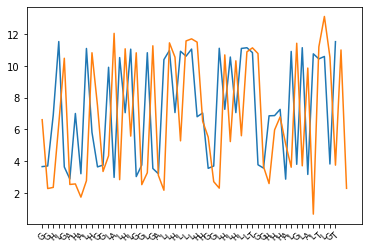

In [149]:
plt.plot(list(outs_val["111m"].values()))
plt.plot(pyp)
plt.xticks(range(len(outs_val["111m"])), [k[0] for k in outs_val["111m"].keys()], rotation=45, fontsize=8)


In [182]:
outs_val["111m"]

{'GLU5A': 3.6614752,
 'GLU7A': 3.7015295,
 'HIS13A': 6.904503,
 'LYS17A': 11.53557,
 'GLU19A': 3.6397069,
 'ASP21A': 2.8822436,
 'HIS25A': 7.0057755,
 'ASP28A': 3.2122722,
 'LYS35A': 11.100159,
 'HIS37A': 5.821362,
 'GLU39A': 3.6445308,
 'GLU42A': 3.7574067,
 'LYS43A': 9.915466,
 'ASP45A': 2.9819636,
 'LYS48A': 10.527309,
 'HIS49A': 7.0563107,
 'LYS51A': 11.056099,
 'GLU53A': 3.0339026,
 'GLU55A': 3.7634654,
 'LYS57A': 10.831911,
 'GLU60A': 3.544126,
 'ASP61A': 3.2108169,
 'LYS63A': 10.398195,
 'LYS64A': 10.975306,
 'HIS65A': 7.0646095,
 'LYS78A': 10.92285,
 'LYS79A': 10.614771,
 'LYS80A': 11.062555,
 'HIS82A': 6.8014517,
 'HIS83A': 7.035763,
 'GLU84A': 3.553093,
 'GLU86A': 3.698472,
 'LYS88A': 11.112825,
 'HIS94A': 7.268468,
 'LYS97A': 10.560747,
 'HIS98A': 7.0616617,
 'LYS99A': 11.102276,
 'LYS103A': 11.146502,
 'TYR104A': 10.839798,
 'GLU106A': 3.7775664,
 'GLU110A': 3.568153,
 'HIS114A': 6.85989,
 'HIS117A': 6.8740807,
 'HIS120A': 7.26425,
 'ASP127A': 2.8723912,
 'LYS134A': 10.9137

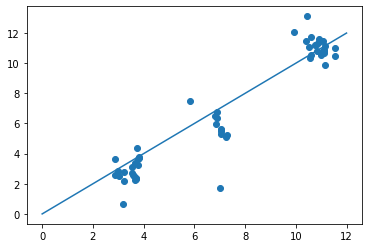

In [152]:
plt.scatter(list(outs_val["111m"].values()), pyp[1:-1])
plt.plot(range(13))

In [173]:
fails

['111m',
 '110m',
 '108m',
 '109m',
 '106m',
 '103m',
 '107m',
 '103l',
 '102m',
 '102l',
 '101m',
 '104l']

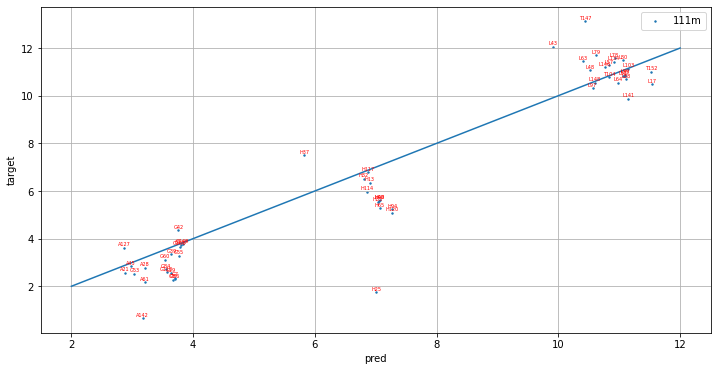

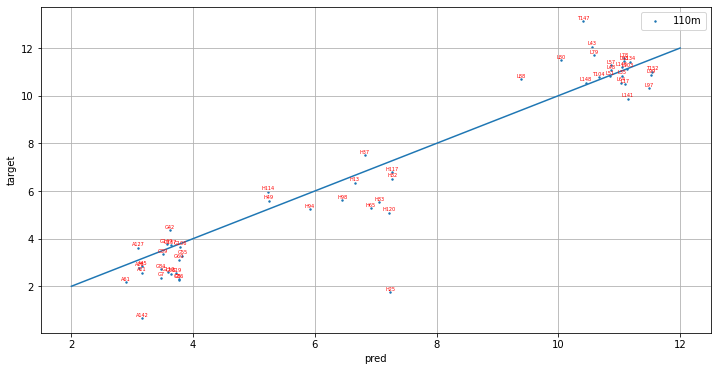

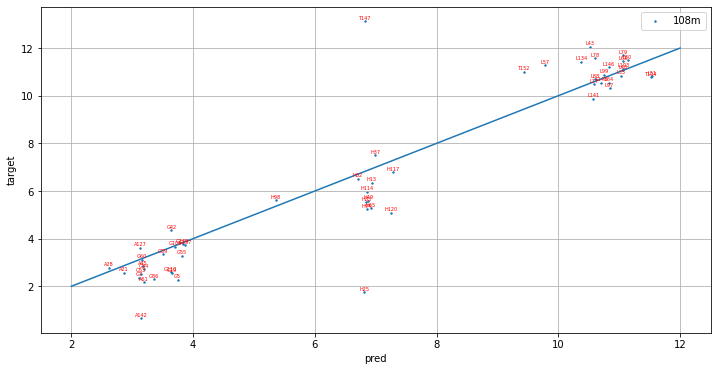

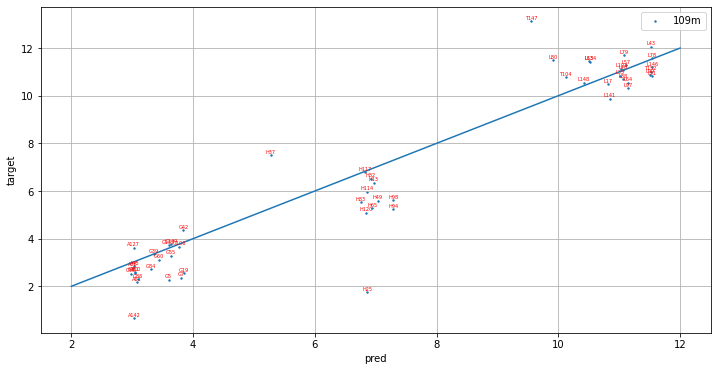

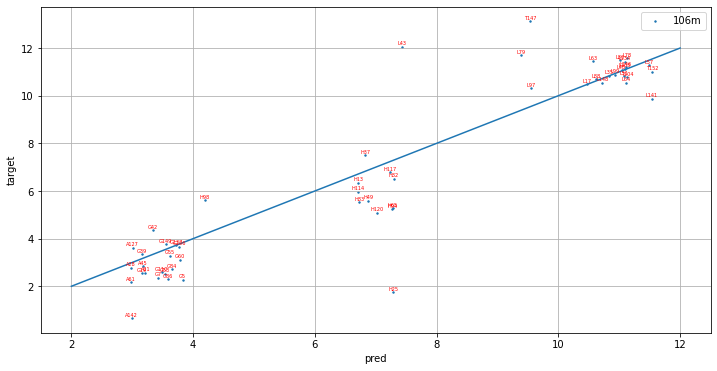

103m


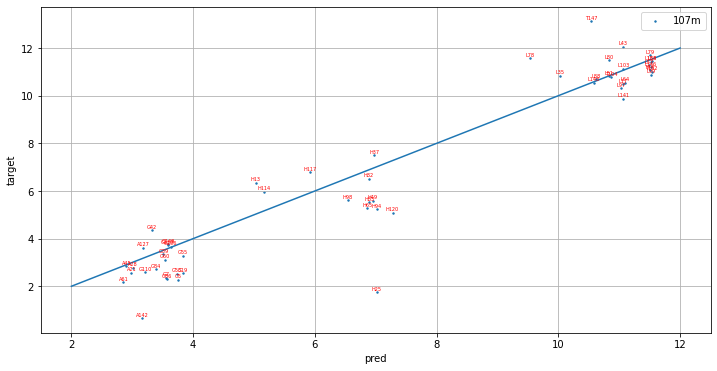

103l
102m
102l


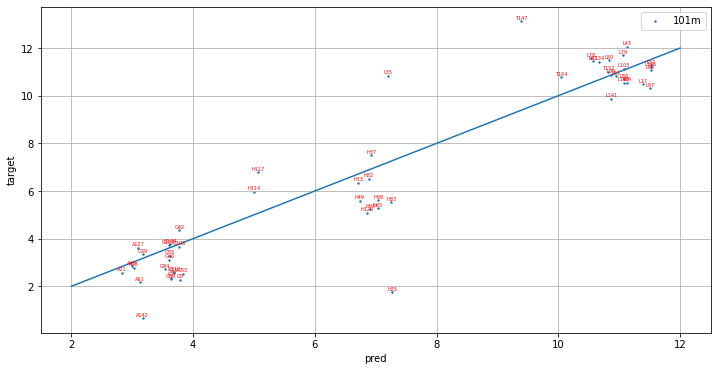

104l


In [184]:
import matplotlib.pyplot as plt

# Example data
#x = list(range(len(outs_val["111m"])))  # X values (index)
#y = list(outs_val["111m"].values())  # Y values (numeric data)
for pd in fails:
    x,y=list(outs_val[pd].values()), pyp[1:-1]
    if len(x)==len(y):
    
        plt.figure(figsize=(12, 6))
        x,y=list(outs_val[pd].values()), pyp[1:-1]
        # Scatter plot with small points
        plt.scatter(x,y, s=2, label=pd)  # `s=5` makes points smaller
        labels=[k[0]+k[3:-1] for k in outs_val[pd].keys()]
        # Annotate each point with only the first letter of its value
        for i in range(len(x)):
            label = labels[i] # First letter of the value
            plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0, 2),
                        ha="center", fontsize=5, color="red")

        plt.plot(range(2,13),range(2,13))

        plt.xlabel("pred")
        plt.ylabel("target")
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print(pd)


In [84]:
outs2

{'10gs': {'TYR3A': 12.241243,
  'TYR7A': 9.992758,
  'CYS14A': 1.8577654,
  'ASP23A': 2.6118472,
  'LYS29A': 8.288166,
  'GLU30A': 2.0764036,
  'GLU31A': 2.6264453,
  'GLU36A': 3.082324,
  'GLU40A': 4.1402225,
  'LYS44A': 10.451363,
  'CYS47A': 5.720317,
  'TYR49A': 13.57588,
  'LYS54A': 14.046604,
  'ASP57A': 7.3318458,
  'ASP59A': 5.673253,
  'TYR63A': 9.055871,
  'HIS71A': 4.877515,
  'TYR79A': 8.898472,
  'LYS81A': 10.590946,
  'ASP82A': 4.49314,
  'GLU85A': 4.016248,
  'ASP90A': 2.5784245,
  'ASP94A': 1.9138052,
  'GLU97A': 1.5825927,
  'ASP98A': 0.81982064,
  'CYS101A': 1.0380249,
  'LYS102A': 8.420016,
  'TYR103A': 10.698648,
  'TYR108A': 12.345486,
  'TYR111A': 8.74176,
  'GLU112A': 2.2069817,
  'LYS115A': 10.014381,
  'ASP116A': 2.64243,
  'ASP117A': 3.3464024,
  'TYR118A': 12.173979,
  'LYS120A': 11.096049,
  'LYS127A': 9.999535,
  'GLU130A': 3.4181526,
  'LYS140A': 9.406173,
  'ASP146A': 3.1580005,
  'ASP152A': 2.9361567,
  'TYR153A': 10.984007,
  'ASP157A': 3.4372072,
  'HI

In [80]:
fails
len(all_targets.keys())
fails
all_data["111m"]["ions"]

{'GLU5A': tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
         -1.]),
 'GLU7A': tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
         -1.]),
 'HIS13A': tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  0.,
          1.,  0.,  1.]),
 'LYS17A': tensor([-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.]),
 'GLU19A': tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
         -1.]),
 'ASP21A': tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.]),
 'HIS25A': tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  0.,
          1.,  0.,  1.]),
 'ASP28A': tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.]),
 'LYS35A': tensor([-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.]),
 'HIS37A': tens

In [ ]:
pnet = EGNN_Network(
        num_tokens = 6, #vocabulary siye, number of unique species
        num_positions = 23,  #number of nodes         # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = 2,# #internal rep size. c has square dependence. richer rep but overfitting for small d.s.
        depth = 2, #number of layers #deeper need more memort to store intermediate reps
        num_nearest_neighbors = 2, #number of nearest neighbors to consider #make this the max hood size
        dropout=.05,
        m_pool_method='mean')
    
#net, optimizer = model(23, 3, 2, .01, .01) # dim, depth, lr, weight decay

optimizer3 = torch.optim.Adam(pnet.parameters(), lr=.01, weight_decay=.1)

In [5]:

outs={}

for pdb in pdbs:
    #print(pdb)
    maxes, Ns, scs=[],[],[]

    d = all_data[pdb]
    pos, hs, ions = d["pos"], d["Hs"], d["ions"]
    outie = {}

    
    for sample in pos.keys():

        coords = torch.tensor(tuple(pos[sample].values()))
        #species = torch.tensor(hs[sample], dtype=int) #todo
        L = coords.shape[0]
        
        x = loop(10, coords, torch.tensor(hs[sample], dtype=int), ions[sample], net, optimizer, 1) #margin, negative slope
        #out = torch.mean(x, dim=1)
        f = torch.mean(x, dim=1).unsqueeze(0).detach().numpy()*coords.detach().numpy().T
        #combined = np.column_stack(f).flatten()
        
        D=np.gradient(np.gradient(np.column_stack(f).flatten())).reshape(-1,3)
        #plot(x[0], D)

        def loop2(D, sample):
            maxes=[]#,[],[]

            r = sample[:3]
            #out = torch.mean(x, dim=1)
            

            loss = torch.nn.HuberLoss()
            
            optimizer3 = torch.optim.Adam(pnet.parameters(), lr=.1, weight_decay=.1)
            

            ins = torch.ones(L)
            ins[0]=0
            ins[-1] = 2#,10,10

            

            for epoch in range(200):
                optimizer3.zero_grad()
                y=pnet(torch.tensor(ins, dtype=int).unsqueeze(0), torch.tensor(D).unsqueeze(0))[0]
                label=labels[r]
                loss2=loss(max(y[0][1::]), torch.tensor(label))
                loss2.backward()
                print("fake", sample, epoch, pdb, loss2)
                optimizer3.step()

            #a=y[0].detach().numpy()
            #maxes.append((np.where(a == max(a[1::]))[0], max(a[1::])))
            #maxes.append(max(a[1::]))
            #Ns.append(a[0])
            #scs.append(a[-1])
            #print(loss2.item())


            return max(y[0].detach().numpy()[1::]) # maxes#, Ns, scs
        
        
        #m = loop2(D, sample)
        #print(sample)

        outie[sample] = loop2(D, sample)

    outs[pdb] = outie
        #coords = torch.tensor()
    #x["ions"], x[""]
    #n#et, optimizer = model(x["lengths, 3, 2, .01, .01) # dim, depth, lr, weight decay



10gs


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(0.0008, grad_fn=<DivBackward0>)
fake TYR3A 0 10gs tensor(7.7298, grad_fn=<HuberLossBackward0>)
fake TYR3A 1 10gs tensor(7.3296, grad_fn=<HuberLossBackward0>)
fake TYR3A 2 10gs tensor(6.9160, grad_fn=<HuberLossBackward0>)
fake TYR3A 3 10gs tensor(6.4950, grad_fn=<HuberLossBackward0>)
fake TYR3A 4 10gs tensor(6.0611, grad_fn=<HuberLossBackward0>)
fake TYR3A 5 10gs tensor(5.6093, grad_fn=<HuberLossBackward0>)
fake TYR3A 6 10gs tensor(5.1363, grad_fn=<HuberLossBackward0>)
fake TYR3A 7 10gs tensor(4.6462, grad_fn=<HuberLossBackward0>)
fake TYR3A 8 10gs tensor(4.1394, grad_fn=<HuberLossBackward0>)
fake TYR3A 9 10gs tensor(3.6149, grad_fn=<HuberLossBackward0>)
fake TYR3A 10 10gs tensor(3.0685, grad_fn=<HuberLossBackward0>)
fake TYR3A 11 10gs tensor(2.6878, grad_fn=<HuberLossBackward0>)


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:972: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


fake TYR3A 12 10gs tensor(1.7306, grad_fn=<HuberLossBackward0>)
fake TYR3A 13 10gs tensor(5.8473, grad_fn=<HuberLossBackward0>)
fake TYR3A 14 10gs tensor(0.4865, grad_fn=<HuberLossBackward0>)
fake TYR3A 15 10gs tensor(0.2884, grad_fn=<HuberLossBackward0>)
fake TYR3A 16 10gs tensor(0.1077, grad_fn=<HuberLossBackward0>)
fake TYR3A 17 10gs tensor(0.3363, grad_fn=<HuberLossBackward0>)
fake TYR3A 18 10gs tensor(0.0102, grad_fn=<HuberLossBackward0>)
fake TYR3A 19 10gs tensor(0.0640, grad_fn=<HuberLossBackward0>)
fake TYR3A 20 10gs tensor(0.0743, grad_fn=<HuberLossBackward0>)
fake TYR3A 21 10gs tensor(0.0157, grad_fn=<HuberLossBackward0>)
fake TYR3A 22 10gs tensor(0.0071, grad_fn=<HuberLossBackward0>)
fake TYR3A 23 10gs tensor(6.1350e-06, grad_fn=<HuberLossBackward0>)
fake TYR3A 24 10gs tensor(0.0058, grad_fn=<HuberLossBackward0>)
fake TYR3A 25 10gs tensor(0.0282, grad_fn=<HuberLossBackward0>)
fake TYR3A 26 10gs tensor(0.0011, grad_fn=<HuberLossBackward0>)
fake TYR3A 27 10gs tensor(0.0365, gr

KeyboardInterrupt: 

/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


RuntimeError: cannot call get_autograd_meta() on undefined tensor

In [19]:
len(Ds.keys())
len(fails)

7

In [24]:
all_data["108l"]["targets"].keys() == all_data["111l"]["targets"].keys()

True

In [89]:
pnet = EGNN_Network(
        num_tokens = 6, #vocabulary siye, number of unique species
        num_positions = 23,  #number of nodes         # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = 2,# #internal rep size. c has square dependence. richer rep but overfitting for small d.s.
        depth = 3, #number of layers #deeper need more memort to store intermediate reps
        num_nearest_neighbors = 2, #number of nearest neighbors to consider #make this the max hood size
        dropout=.1,
        m_pool_method='mean')

optimizer3 = torch.optim.Adam(pnet.parameters(), lr=.001, weight_decay=.01)

In [ ]:
for pdb in [pdbs[5]]:
    
    maxes, Ns, scs, outie =[],[],[],{}

    d = all_data[pdb]
    pos, hs, ions, T = d["pos"], d["Hs"], d["ions"], d["targets"]
    
    for sample in pos.keys():

        coords = torch.tensor(tuple(pos[sample].values()))
        #species = torch.tensor(hs[sample], dtype=int) #todo
        L = coords.shape[0]
        #net, optimizer = model(L, 3, 2, .01, .01) # dim, depth, lr, weight decay
        x = loop(10, coords, torch.tensor(hs[sample], dtype=int), ions[sample], net, optimizer, 1) #margin, negative slope
        #out = torch.mean(x, dim=1)
        f = torch.mean(x, dim=1).unsqueeze(0).detach().numpy()*coords.detach().numpy().T
        #combined = np.column_stack(f).flatten()
        
        D=np.gradient(np.gradient(np.column_stack(f).flatten())).reshape(-1,3)

        print(L)

/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


RuntimeError: cannot call get_autograd_meta() on undefined tensor

In [112]:
net, optimizer = model(23, 3, 2, .01, .01) # dim, depth, lr, weight decay#

In [108]:
del(all_data["1"])

In [1]:
#r = sample[:3]
            #out = torch.mean(x, dim=1)

Ds = {}
for pdb in pdbs[:15]:
    #pdb="104l"
    
    maxes, Ns, scs =[],[],[]

    d = all_data[pdb]
    
    pos, hs, ions = d["pos"], d["Hs"], d["ions"]#, d["targets"]
    
    
    for sample in pos.keys():
        label=all_targets[pdb][sample]

        coords = torch.tensor(tuple(pos[sample].values()))
        #species = torch.tensor(hs[sample], dtype=int) #todo
        L = coords.shape[0]
        print(sample)
        #net, optimizer = model(L, 3, 2, .01, .01) # dim, depth, lr, weight decay
        x = loop(10, coords, torch.tensor(hs[sample], dtype=int), ions[sample], net, optimizer, 1) #margin, negative slope
        print("")
        #out = torch.mean(x, dim=1)
        #f = torch.mean(x, dim=1).unsqueeze(0).detach().numpy()*coords.detach().numpy().T
        #combined = np.column_stack(f).flatten()
        
        #D=np.gradient(np.gradient(np.column_stack(f).flatten())).reshape(-1,3)
        Ds[pdb] = np.gradient(np.gradient(np.column_stack(torch.mean(x, dim=1).unsqueeze(0).detach().numpy()*coords.detach().numpy().T).flatten())).reshape(-1,3)
        
        #loss = torch.nn.HuberLoss()




        
    
    #losses[pdb] = loss2

    #outs2[pdb] = outie
        

NameError: name 'pdbs' is not defined

In [102]:
all_targets["104l"]

KeyError: '104l'

In [ ]:
all_data["109m"]["pos"]

{'GLU5A': {0: (32.009, 18.561, -13.362),
  1: (31.918, 18.195, -14.31),
  2: (33.354, 19.012, -12.992),
  3: (33.895, 18.202, -12.503),
  4: (33.234, 20.252, -12.077),
  5: (33.977, 20.384, -11.109),
  6: (34.173, 19.347, -14.254),
  7: (33.75, 20.031, -14.99),
  8: (34.326, 18.509, -14.934),
  9: (35.521, 20.04, -14.013),
  10: (35.462, 21.106, -13.792),
  11: (36.077, 20.073, -14.95),
  12: (36.543, 19.16, -13.319),
  13: (36.366, 17.925, -13.308),
  14: (37.539, 19.697, -12.792)},
 'GLU7A': {0: (30.947, 20.938, -9.879),
  1: (30.523, 20.545, -10.719),
  2: (30.587, 20.503, -8.528),
  3: (30.246, 21.427, -8.061),
  4: (31.836, 19.916, -7.825),
  5: (32.106, 20.238, -6.665),
  6: (29.422, 19.502, -8.573),
  7: (29.664, 18.668, -9.232),
  8: (29.241, 19.097, -7.577),
  9: (28.083, 20.17, -8.944),
  10: (28.015, 20.802, -9.83),
  11: (27.639, 20.75, -8.135),
  12: (26.945, 19.185, -9.247),
  13: (27.206, 18.058, -9.707),
  14: (25.779, 19.559, -9.039)},
 'HIS13A': {0: (37.845, 22.512, -

In [ ]:
a

In [ ]:
T["GLU5A"]

KeyError: 'GLU5A'